**Visualization**

1. Menghasilkan Peta Penutup Lahan

In [5]:
!pip install rasterio

import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import joblib


In [6]:
# Open raster file (Sentinel-2 data)
raster = rasterio.open('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/S2_with_SpectralIndices.tif')

# import AOi kita menggunakan geopandas
AOI = gpd.read_file('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/AOI.shp')


In [7]:
# Load saved model
loaded_model = joblib.load('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/best_xgb_model.pkl')

In [8]:
# Apply model untuk mengkelasifikasikan keseluruhan citra
def classify_raster(raster, model):
    raster_data = raster.read().reshape((raster.count, -1)).T  # Reshape to (pixels, bands)
    mask = np.isnan(raster_data).any(axis=1)  # Exclude NaN pixels
    classified = np.full(raster_data.shape[0], np.nan)
    classified[~mask] = model.predict(raster_data[~mask])
    return classified.reshape((raster.height, raster.width))

In [9]:
# Mengklasifikasikan data dengan best model yang telah dibuat
classified_map = classify_raster(raster, loaded_model)

2. Visualisasi peta statis di python (hasil Klasifikasi)

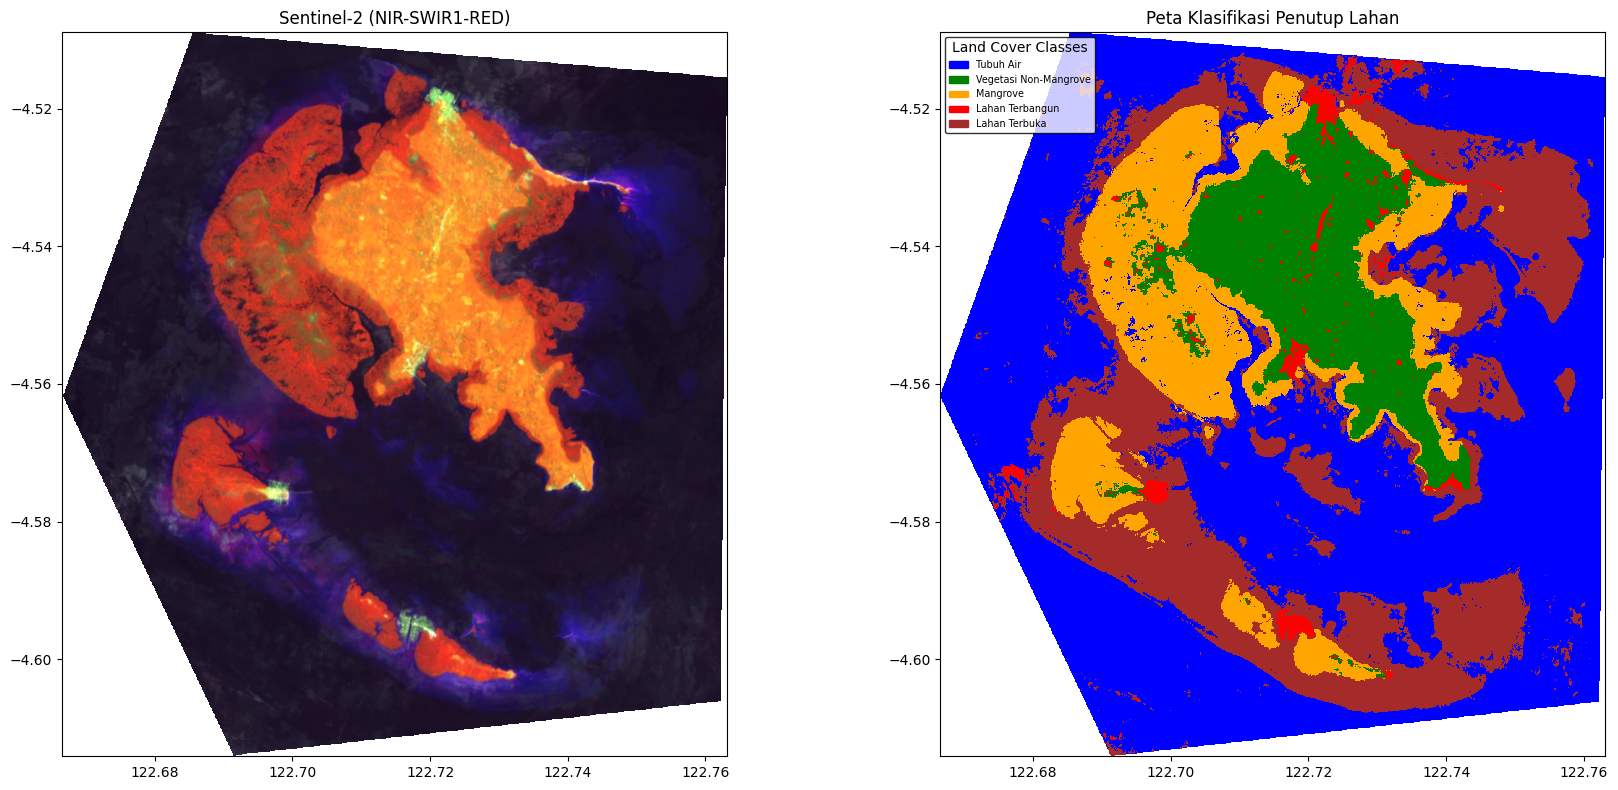

In [10]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

# Mendefinisikan Legend dan warna untuk setiap kelas
legend_labels = ['Tubuh Air', 'Vegetasi Non-Mangrove', 'Mangrove', 'Lahan Terbangun', 'Lahan Terbuka']
legend_colors = ['blue', 'green', 'orange', 'Red', 'Brown']

# Membuat figure untuk dua subplot: 1 untuk Sentinel-2 dan 2. untuk  hasil klasifikasi penutup lahan
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Display Original Sentinel-2 image (NIR-SWIR1-RED)
rgb = np.stack([raster.read(4), raster.read(5), raster.read(3)], axis=-1)
brightness_factor = 3.5
S2_Vis_rgb = np.clip(rgb * brightness_factor, 0, 1)

ax[0].imshow(S2_Vis_rgb, extent=[AOI.total_bounds[0], AOI.total_bounds[2],AOI.total_bounds[1], AOI.total_bounds[3]])
ax[0].set_title('Sentinel-2 (NIR-SWIR1-RED)')

# Klasifikasi penutup lahan
# Mendefinisikan colormap
cmap = ListedColormap(legend_colors)

# Display hasil klasifikasi penutup lahan
im = ax[1].imshow(classified_map, cmap=cmap, interpolation='nearest', extent=[AOI.total_bounds[0], AOI.total_bounds[2],AOI.total_bounds[1], AOI.total_bounds[3]])
ax[1].set_title('Peta Klasifikasi Penutup Lahan')

# Membuat legend
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
# menambahkan legend kedalam plot
ax[1].legend(handles=legend_handles, loc='upper left', title="Land Cover Classes", fontsize='x-small', title_fontsize='medium', edgecolor="black", fancybox=True)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
## Menyimpan Hasil klasifikasi ke dalam format raster (.tif)
import rasterio
from rasterio.transform import from_origin

def export_classified_map(classified_map, reference_raster, output_path):
    meta = reference_raster.meta.copy()

    # Buat salinan agar aman
    classified_clean = np.nan_to_num(classified_map, nan=-1)  # nodata = -1

    meta.update({
        "driver": "GTiff",
        "dtype": 'int32',
        "count": 1,
        "compress": "lzw",
        "nodata": -1
    })

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_clean.astype('int32'), 1)

In [12]:
# Menerapkan fungsi yang telah dibuat
output_tif_path = '/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/classification_Map_xgboost.tif'
export_classified_map(classified_map, raster, output_tif_path)

3. Visualisasi Peta Interaktif dengan leaflet

In [13]:
from google.colab import output
output.enable_custom_widget_manager()

In [14]:
!pip install leafmap
!pip install mapclassify

from leafmap import leafmap
import matplotlib.colors as mcolors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.8/632.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 13.5

In [15]:
LC = gpd.read_file('/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/Landcover-Pulau Tobea Besar-2024.shp')
print(LC)

     fid  DN                                           geometry
0    3.0   0  MULTIPOLYGON (((122.68705 -4.58473, 122.68678 ...
1  371.0   1  MULTIPOLYGON (((122.69002 -4.57647, 122.68975 ...
2  378.0   2  MULTIPOLYGON (((122.69496 -4.58213, 122.69478 ...
3    2.0   3  MULTIPOLYGON (((122.69019 -4.61141, 122.69019 ...
4    1.0   4  MULTIPOLYGON (((122.67915 -4.58177, 122.67906 ...


In [16]:
# Mendapatkan bounds dari GeoDataFrame (AOI Pulau Tobea Besar)
bounds = LC.to_crs('EPSG:4326').total_bounds  # [minx, miny, maxx, maxy]
bounds

array([122.66647918,  -4.61410663, 122.76313791,  -4.50891391])

In [17]:
# Menghitung center dari bounding box
center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
center

[np.float64(-4.561510265466312), np.float64(122.71480854478929)]

In [18]:
# Mendapatkan bounds dari GeoDataFrame (AOI Pulau Tobea Besar)
bounds = LC.to_crs('EPSG:4326').total_bounds  # [minx, miny, maxx, maxy]

# Menghitung center dari bounding box
center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]

# Mapping nilai DN ke nama kategori
kategori_mapping = {
    0: "Badan Air",
    1: "Vegetasi Non Mangrove",
    2: "Mangrove",
    3: "Lahan Terbangun",
    4: "Lahan Terbuka"
}

# Buat kolom baru bernama 'Kategori'
LC['Kategori'] = LC['DN'].map(kategori_mapping)

# Define the list of colors
legend_colors = ['blue', 'red', 'brown', 'orange', 'green']

# Create a custom colormap from the list of colors
cmap = mcolors.ListedColormap(legend_colors)

# Create an interactive map
m = leafmap.Map(center=center, zoom=13)
m.add_data(
    LC,
    column="Kategori",  # Ganti dari "DN" ke "Kategori"
    cmap=cmap,  # Gunakan cmap untuk warna
    legend_title="Klasifikasi Tutupan Lahan",
    layer_name="Tutupan Lahan Teluk Pulau Tobea Besar",
    style={'fillOpacity': 0.7, 'weight': 0}  # weight: 0 menghilangkan garis tepi
)
m

Map(center=[np.float64(-4.561510265466312), np.float64(122.71480854478929)], controls=(ZoomControl(options=['p…

In [19]:
m.to_html("/content/drive/MyDrive/    Training-Tutupan-Lahan-berbasis-Machine-Learning/Miniproject/data/peta_tobea_besar.html")
